In [41]:
from tqdm import tqdm
import numpy as np
import pandas as pd
#from utils import extract_basic_features

#import wfdb
import os
#import wfdb.processing as wp
import matplotlib.pyplot as plt
from scipy import signal
#from utils import find_noise_features, extract_basic_features
import shutil
import gc
import time
import random as rn
#from lightgbm import LGBMClassifier
from scipy import sparse
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold,StratifiedKFold
#from xgboost import XGBClassifier

import warnings
import scipy.io as sio

#from resnet_ecg.utils import one_hot,get_batches
from resnet_ecg.ecg_preprocess import ecg_preprocessing
from resnet_ecg.densemodel import Net

from keras.utils import to_categorical
from keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.layers import Input
from keras.models import Model,load_model

path = '/media/jdcloud/'

warnings.filterwarnings("ignore")

config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)
KTF.set_session(session )

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
tf.set_random_seed(1234)

class Config(object):
    def __init__(self):
        self.conv_subsample_lengths = [1, 2, 1, 2, 1, 2, 1, 2]
        self.conv_filter_length = 32
        self.conv_num_filters_start = 12
        self.conv_init = "he_normal"
        self.conv_activation = "relu"
        self.conv_dropout = 0.5
        self.conv_num_skip = 2
        self.conv_increase_channels_at = 2
        self.batch_size = 32#128
        self.input_shape = [2560, 12]#[1280, 1]
        self.num_categories = 2

    @staticmethod
    def lr_schedule(epoch):
        lr = 0.1
        if epoch >= 10 and epoch < 20:
            lr = 0.01
        if epoch >= 20:
            lr = 0.001
        print('Learning rate: ', lr)
        return lr


import keras.backend as K


def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)



def read_data_seg(data_path, split="Train", preprocess=False, fs=500, newFs=256, winSecond=10, winNum=10, 
                  n_index=0):
    """ Read data """

    # Fixed params
    # n_index = 0
    n_class = 9
    winSize = winSecond * fs
    new_winSize = winSecond * newFs
    # Paths
    path_signals = os.path.join(data_path, split)

    # Read labels and one-hot encode
    # label_path = os.path.join(data_path, "reference.txt")
    # labels = pd.read_csv(label_path, sep='\t',header = None)
    # labels = pd.read_csv("reference.csv")

    # Read time-series data
    channel_files = os.listdir(path_signals)
    # print(channel_files)
    channel_files.sort()
    n_channels = 12  # len(channel_files)
    # posix = len(split) + 5

    # Initiate array
    list_of_channels = []

    X = np.zeros((len(channel_files), new_winSize, n_channels)).astype('float32') 
    i_ch = 0

    channel_name = ['V6', 'aVF', 'I', 'V4', 'V2', 'aVL', 'V1', 'II', 'aVR', 'V3', 'III', 'V5']
    channel_mid_name = ['II', 'aVR', 'V2', 'V5']
    channel_post_name = ['III', 'aVF', 'V3', 'V6']

    for i_ch, fil_ch in enumerate(channel_files[:]):  # tqdm
        
        if i_ch % 1000 == 0:
            print(i_ch)
            
        ecg = sio.loadmat(os.path.join(path_signals, fil_ch))
        ecg_length = ecg["I"].shape[1]

        if ecg_length > fs * winNum * winSecond:
            print(" too long !!!", ecg_length)
            ecg_length = fs * winNum * winSecond
        if ecg_length < 4500:
            print(" too short !!!", ecg_length)
            break

        slide_steps = int((ecg_length - winSize) / (winNum-1))#int((ecg_length - winSize) / winSecond)

        if ecg_length <= 4500:
            slide_steps = 0

        ecg_channels = np.zeros((new_winSize, n_channels)).astype('float32') 

        for i_n, ch_name in enumerate(channel_name):

            ecg_channels[:, i_n] = signal.resample(ecg[ch_name]
                                                   [:, n_index * slide_steps:n_index * slide_steps + winSize].T
                                                   , new_winSize).T
            if preprocess:
                #data = ecg_preprocessing(ecg_channels[:, i_n].reshape(1, new_winSize), 'sym8', 8, 3, newFs,
                #                        removebaseline=False,normalize=False)
                #ecg_channels[:, i_n] = data[0]
                ecg_channels[:,i_n] = wavelet(ecg_channels[:,i_n],'db4',4,2,4)
                #ecg_channels[:,i_n] = wavelet_db6(ecg_channels[:,i_n]) 
            else:
                print("no preprocess")
                ecg_channels[:, i_n] = ecg_channels[:, i_n]

        X[i_ch, :, :] = ecg_channels

    return X


def preprocess_y(labels,y,num_class=9):
    bin_label = np.zeros((len(y),num_class)).astype('int8') 
    for i in range(len(y)):
        label_nona = labels.loc[y[i]].dropna()
        for j in range(1,label_nona.shape[0]):
            bin_label[i,int(label_nona[j])]=1
    return bin_label


def add_compile(model, config):
    optimizer = SGD(lr=config.lr_schedule(0), momentum=0.9)  # Adam()#
    model.compile(loss='binary_crossentropy',  # weighted_loss,#'binary_crossentropy',
                  optimizer='adam',  # optimizer,#'adam',
                  metrics=['accuracy', fmeasure, precision])#recall
    # ['accuracy',fbetaMacro,recallMacro,precisionMacro])
    # ['accuracy',fmeasure,recall,precision])

In [6]:
labels_en = pd.read_csv(path + "kfold_labels_en.csv")

In [7]:
import keras

def preprocess_y(labels,y,num_class=9):
    bin_label = np.zeros((len(y),num_class)).astype('int8') 
    for i in range(len(y)):
        label_nona = labels.loc[y[i]].dropna()
        for j in range(1,label_nona.shape[0]):
            bin_label[i,int(label_nona[j])]=1
    return bin_label

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size,  *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        #print(len(list_IDs_temp))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load("training_data/" + ID+".npy")
            #ecg = sio.loadmat("preliminary/TRAIN/" + ID)
            #X[i,] = signal.resample(ecg['data'].T,2560)
            #print(ID.strip(".mat"))
            # Store class
            #print(ID.split("_")[0])
            #print(X[i,].shape) 
            #print(preprocess_y(self.labels,self.labels[self.labels["File_name"]==ID.split("_")[0]].index))
            y[i,:] = preprocess_y(self.labels,self.labels[self.labels["File_name"]==ID.split("_")[0]].index)
            #print(y[i,:])
        X_list = [X[:,0],X[:,1],X[:,2],X[:,3],X[:,4],X[:,5],X[:,6],X[:,7],X[:,8],X[:,9]] 
        #print(X[:,0].shape) 
        #print(y)
        del X
        #print(y.shape)
        return X_list, y# keras.utils.to_categorical(y, num_classes=self.n_classes)

In [8]:
raw_IDs = labels_en["File_name"].values.tolist()

In [9]:
extend_db4_IDs = [i+"_db4" for i in raw_IDs]
extend_db6_IDs = [i+"_db6" for i in raw_IDs]

In [10]:
all_IDs = raw_IDs + extend_db4_IDs + extend_db6_IDs

In [11]:
np.random.shuffle(all_IDs)

In [23]:
int(0.8*len(all_IDs))

18487

In [13]:
labels = pd.read_csv(path+"reference.csv")

In [14]:
labels_en[labels_en["File_name"]=="TRAIN0405_db4".split("_")[0]]

,File_name,age,dataSize,label1,label2,label3,label4,label5,label6,label7,label8,labels_num,sex
447,TRAIN0405,28,5000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FEMALE


In [15]:
X = np.load("training_data/" +"TRAIN0010_db6"+".npy") 

In [16]:
import scipy.io as sio
import os
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import wfdb.processing as wp
warnings.filterwarnings('ignore')

In [35]:
import pywt

def wavelet(ecg,wavefunc,lv,m,n):   #
    
    coeff = pywt.wavedec(ecg,wavefunc,mode='sym',level=lv)   #
    #sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0

    for i in range(m,n+1):  
        cD = coeff[i]
        for j in range(len(cD)):
            Tr = np.sqrt(2*np.log(len(cD)))  
            if cD[j] >= Tr:
                coeff[i][j] = np.sign(cD[j]) - Tr 
            else:
                coeff[i][j] = 0   
                
    denoised_ecg = pywt.waverec(coeff,wavefunc)
    return denoised_ecg

def wavelet_db6(sig):
    """
    R J, Acharya U R, Min L C. ECG beat classification using PCA, LDA, ICA and discrete
     wavelet transform[J].Biomedical Signal Processing and Control, 2013, 8(5): 437-448.

    param sig: 1-D numpy Array
    return: 1-D numpy Array
    """
    coeffs = pywt.wavedec(sig, 'db6', level=9)

    coeffs[-1] = np.zeros(len(coeffs[-1]))

    coeffs[-2] = np.zeros(len(coeffs[-2]))

    coeffs[0] = np.zeros(len(coeffs[0]))

    sig_filt = pywt.waverec(coeffs, 'db6')

    return sig_filt
'''
plt.figure(figsize=(20,20))
#ecg_data = X[0][:,0]
#qrs_inds = wp.xqrs_detect(ecg_data, 500)
for i in range(12):
    plt.subplot(6, 2, i+1)
    ecg_data = X[2][:,i]#wavelet(X[0][:,i],'db4',4,2,4)
    plt.plot(ecg_data)
    #plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
    #plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
plt.show()
'''
pass

In [11]:
labels[labels["File_name"]==all_IDs[1000].strip("_db4")]

,File_name,label1,label2,label3,label4,label5,label6,label7,label8
3569,TRAIN3570,2,7.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
y = np.empty((10,9), dtype=int)

In [13]:
y[0] = preprocess_y(labels,labels[labels["File_name"]=="TRAIN4214"].index)

In [14]:
y[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 1])

In [15]:
labels[labels["File_name"]=="TRAIN3827"]

,File_name,label1,label2,label3,label4,label5,label6,label7,label8
3826,TRAIN3827,2,6.0,8.0,NaN,NaN,NaN,NaN,NaN


In [74]:
training_generator = DataGenerator(all_IDs[:int(0.8*len(all_IDs))], labels, **params)
for ii in training_generator:
    #print(i)
    break

In [41]:
ii[0][0][0][:,0].shape

(2560,)

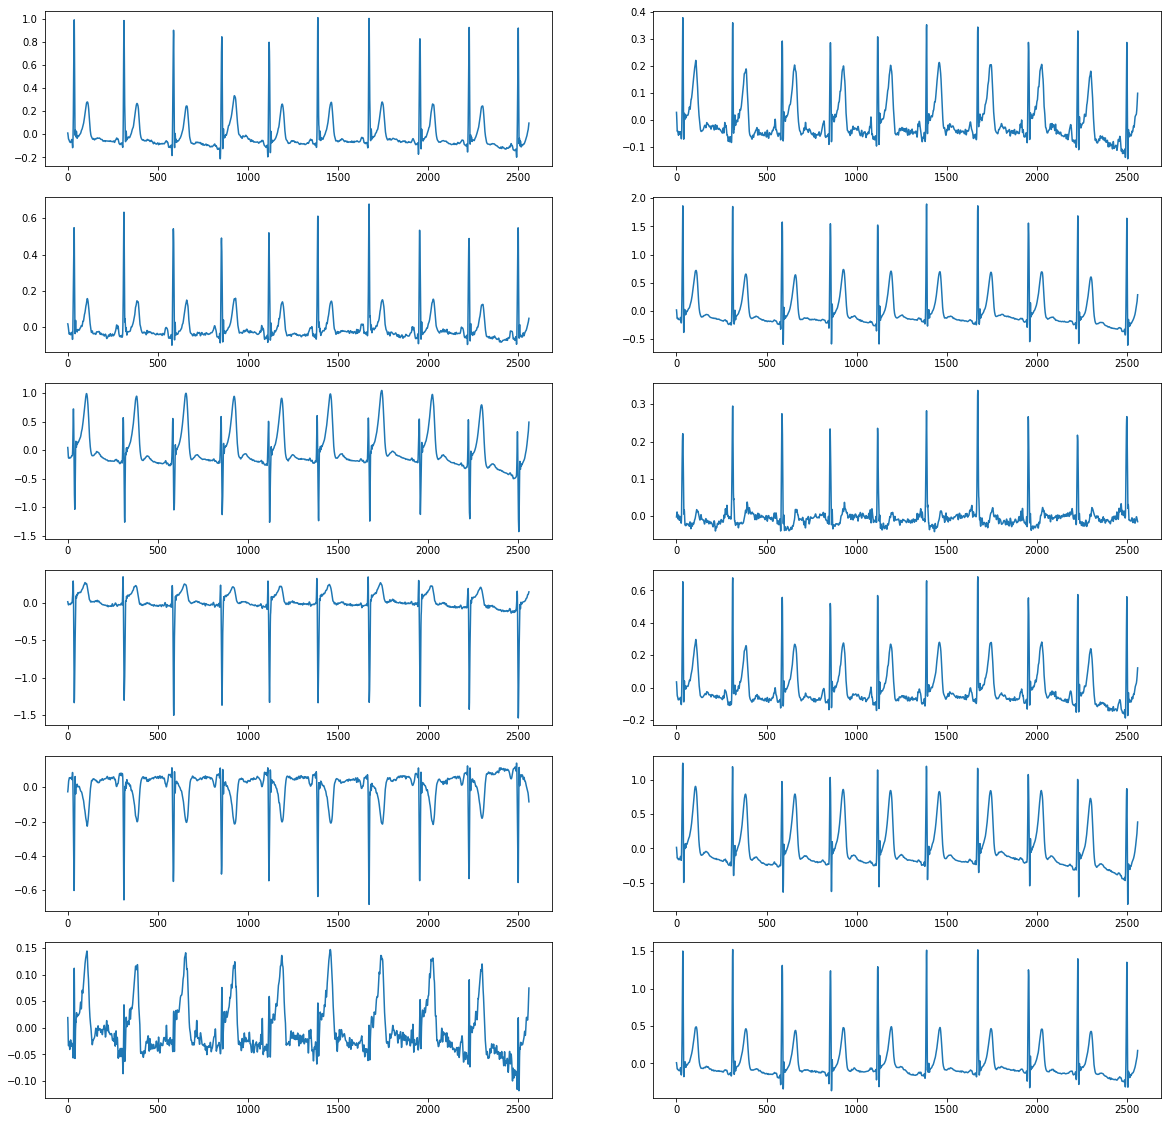

In [21]:
plt.figure(figsize=(20,20))
#ecg_data = X[0][:,0]
#qrs_inds = wp.xqrs_detect(ecg_data, 500)
for i in range(12):
    plt.subplot(6, 2, i+1)
    ecg_data = X[0][:,i]#ii[0][0][0][:,i]#wavelet(X[0][:,i],'db4',4,2,4)
    plt.plot(ecg_data)
    #plt.scatter(hard_peaks, ecg_data[hard_peaks], marker='o', c='r')
    #plt.scatter(qrs_inds, ecg_data[qrs_inds], marker='o', c='g')
plt.show()

In [24]:
# Parameters
params = {'dim': (10,2560),
          'batch_size': 64,
          'n_classes': 9,
          'n_channels': 12,
          'shuffle': True}

# Generators
training_generator = DataGenerator(all_IDs[:int(0.8*len(all_IDs))], labels, **params)
validation_generator = DataGenerator(all_IDs[int(0.2*len(all_IDs)):], labels, **params)


In [25]:
from resnet_ecg import attentionmodel  

from keras.layers import Input
from keras.models import Model,load_model

'''   '''
inputs0 = Input(shape=(2560,12),dtype="float32")
inputs1 = Input(shape=(2560,12),dtype="float32")
inputs2 = Input(shape=(2560,12),dtype="float32")
inputs3 = Input(shape=(2560,12),dtype="float32")
inputs4 = Input(shape=(2560,12),dtype="float32")
inputs5 = Input(shape=(2560,12),dtype="float32")
inputs6 = Input(shape=(2560,12),dtype="float32")
inputs7 = Input(shape=(2560,12),dtype="float32")
inputs8 = Input(shape=(2560,12),dtype="float32")
inputs9 = Input(shape=(2560,12),dtype="float32")

inputs_list = [inputs0,inputs1,inputs2,inputs3,inputs4,inputs5,inputs6,inputs7,inputs8,inputs9]

outputs = attentionmodel.build_network(inputs_list,0.5,num_classes=9,block_size=4,relu=False)

model = Model(inputs =inputs_list,outputs=outputs)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2560, 12)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2560, 12)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2560, 12)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer) 

In [26]:
model_path = './attention_model/'

checkpointer = ModelCheckpoint(filepath=model_path+'tst_ger_attention_weights-best_k{}_r{}.hdf5'.format(5,5),
                               monitor='val_fmeasure', verbose=1, save_best_only=True,
                               save_weights_only=True,
                               mode='max')  # val_fmeasure
reduce = ReduceLROnPlateau(monitor='val_fmeasure', factor=0.5, patience=2, verbose=1, min_delta=1e-4,
                           mode='max')

config = Config()
add_compile(model, config)
''' 
model_name = 'resnet21.h5'
earlystop = EarlyStopping(
    monitor='val_fmeasure',  # 'val_categorical_accuracy',
    patience=10,
)
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_categorical_accuracy', mode='max',
                             save_best_only='True')

lr_scheduler = LearningRateScheduler(config.lr_schedule)
'''
callback_lists = [checkpointer, reduce]  # [checkpointer,lr_scheduler]#
# [checkpointer,earlystop,lr_scheduler]
# [checkpoint, earlystop,lr_scheduler]

history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    epochs=50,              
                    verbose=1, 
                    callbacks=callback_lists)

Learning rate:  0.1
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
288/288 [==============================] - 399s 1s/step - loss: 0.3727 - acc: 0.8560 - fmeasure: 0.4708 - precision: 0.5995 - val_loss: 0.3095 - val_acc: 0.9022 - val_fmeasure: 0.6045 - val_precision: 0.7784

Epoch 00001: val_fmeasure improved from -inf to 0.60454, saving model to ./attention_model/tst_ger_attention_weights-best_k5_r5.hdf5
Epoch 2/50
288/288 [==============================] - 168s 585ms/step - loss: 0.2673 - acc: 0.9012 - fmeasure: 0.6135 - precision: 0.7502 - val_loss: 0.1872 - val_acc: 0.9234 - val_fmeasure: 0.6954 - val_precision: 0.8718

Epoch 00002: val_fmeasure improved from 0.60454 to 0.69543, saving model to ./attention_model/tst_ger_attention_weights-best_k5_r5.hdf5
Epoch 3/50
288/288 [==============================] - 167s 580ms/step - loss: 0.2269 - acc: 0.9155 - fmeasure: 0.6837 - precision: 0.7846 - val_loss: 0.1647 - val_acc: 0.9308 - val_fmeasure: 0.7431 - val_precision: 0.847

In [3]:
#print("train_x shape :", train_x.shape)
       
model_path = './attention_model/'

for seed in range(en_amount):
    print("************************")
    n_fold = 3
    n_classes = 9

    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    kf = kfold.split(train_index, labels_en['label1'])

    blend_train = np.zeros((6500, n_classes)).astype('float32') #len(train_x)
    blend_test = np.zeros((500, n_fold, n_classes)).astype('float32') #len(test_x)

    count = 0

    for i, (index_train, index_valid) in enumerate(kf):
        print('fold: ', i+1, ' training')
        t = time.time()

        index_tr = train_index[index_train]
        index_vld = train_index[index_valid]

        '''  '''
        
        X_tr = [ecg12_seg0[index_tr], ecg12_seg1[index_tr], ecg12_seg2[index_tr], ecg12_seg3[index_tr],
                ecg12_seg4[index_tr], ecg12_seg5[index_tr], ecg12_seg6[index_tr], ecg12_seg7[index_tr],
                ecg12_seg8[index_tr], ecg12_seg9[index_tr],
               ]

        X_vld = [ecg12_seg0[index_vld], ecg12_seg1[index_vld], ecg12_seg2[index_vld], ecg12_seg3[index_vld],
                 ecg12_seg4[index_vld], ecg12_seg5[index_vld], ecg12_seg6[index_vld], ecg12_seg7[index_vld],
                 ecg12_seg8[index_vld], ecg12_seg9[index_vld],
               ]
        
        #X_tr = train_x[index_tr]
        #X_vld = train_x[index_vld]
        #print(index_tr)

        y_tr = preprocess_y(labels,index_tr)
        y_vld = preprocess_y(labels,index_vld)

        #print(y_tr.shape)
        #print(y_vld.shape)
        #print(y_tr[:10])
        #print(y_vld[:10])

        checkpointer = ModelCheckpoint(filepath=model_path+'tst_attention_weights-best_k{}_r{}.hdf5'.format(seed,i),
                                       monitor='val_fmeasure', verbose=1, save_best_only=True,
                                       save_weights_only=True,
                                       mode='max')  # val_fmeasure
        reduce = ReduceLROnPlateau(monitor='val_fmeasure', factor=0.5, patience=2, verbose=1, min_delta=1e-4,
                                   mode='max')

        config = Config()
        add_compile(model, config)
        ''' 
        model_name = 'resnet21.h5'
        earlystop = EarlyStopping(
            monitor='val_fmeasure',  # 'val_categorical_accuracy',
            patience=10,
        )
        checkpoint = ModelCheckpoint(filepath=model_name,
                                     monitor='val_categorical_accuracy', mode='max',
                                     save_best_only='True')

        lr_scheduler = LearningRateScheduler(config.lr_schedule)
        '''
        callback_lists = [checkpointer, reduce]  # [checkpointer,lr_scheduler]#
        # [checkpointer,earlystop,lr_scheduler]
        # [checkpoint, earlystop,lr_scheduler]

        history = model.fit(x=X_tr, y=y_tr, batch_size=64, epochs=20,  # class_weight=cw,#'auto',
                            verbose=1, validation_data=(X_vld, y_vld), callbacks=callback_lists)

        # Evaluate best trained model
        #model.load_weights(model_path+'densenet_weights-best_k{}_r{}.hdf5'.format(seed, i))

        test_y = model.predict(test_x)
        val_y = model.predict(X_vld)
        
        del X_tr
        del X_vld
        
        #K.clear_session()
        gc.collect()
        gc.collect()
        #config = tf.ConfigProto()
        #config.gpu_options.allow_growth=True
        #sess = tf.Session(config=config)
        #K.set_session(sess)

        blend_train[index_vld, :] = val_y
        blend_test[:, i, :] = test_y

        count += 1


************************
fold:  1  training
Learning rate:  0.1
Instructions for updating:
Use tf.cast instead.
Train on 5134 samples, validate on 2569 samples
Epoch 1/20
5134/5134 [==============================] - 147s 29ms/step - loss: 0.4639 - acc: 0.7848 - fmeasure: 0.4211 - precision: 0.4271 - val_loss: 0.3088 - val_acc: 0.8917 - val_fmeasure: 0.4525 - val_precision: 0.6694

Epoch 00001: val_fmeasure improved from -inf to 0.45252, saving model to ./attention_model/tst_attention_weights-best_k0_r0.hdf5
Epoch 2/20
5134/5134 [==============================] - 47s 9ms/step - loss: 0.2948 - acc: 0.8917 - fmeasure: 0.5951 - precision: 0.6973 - val_loss: 0.2370 - val_acc: 0.9144 - val_fmeasure: 0.6535 - val_precision: 0.8776

Epoch 00002: val_fmeasure improved from 0.45252 to 0.65349, saving model to ./attention_model/tst_attention_weights-best_k0_r0.hdf5
Epoch 3/20
5134/5134 [==============================] - 45s 9ms/step - loss: 0.2551 - acc: 0.9066 - fmeasure: 0.6456 - precision: 0.7

In [42]:
test_x_seg0 = read_data_seg(path, split='Val', preprocess=True,n_index=0)
test_x_seg1 = read_data_seg(path, split='Val', preprocess=True,n_index=1)
test_x_seg2 = read_data_seg(path, split='Val', preprocess=True,n_index=2)
test_x_seg3 = read_data_seg(path, split='Val', preprocess=True,n_index=3)
test_x_seg4 = read_data_seg(path, split='Val', preprocess=True,n_index=4)

test_x_seg5 = read_data_seg(path, split='Val', preprocess=True,n_index=5)
test_x_seg6 = read_data_seg(path, split='Val', preprocess=True,n_index=6)
test_x_seg7 = read_data_seg(path, split='Val', preprocess=True,n_index=7)
test_x_seg8 = read_data_seg(path, split='Val', preprocess=True,n_index=8)
test_x_seg9 = read_data_seg(path, split='Val', preprocess=True,n_index=9)


test_x = [test_x_seg0, test_x_seg1, test_x_seg2, test_x_seg3, test_x_seg4,
          test_x_seg5, test_x_seg6, test_x_seg7, test_x_seg8, test_x_seg9,
         ]

del test_x_seg0, test_x_seg1, test_x_seg2, test_x_seg3, test_x_seg4
del test_x_seg5, test_x_seg6, test_x_seg7, test_x_seg8, test_x_seg9

gc.collect()

0
0
0
0
0
0
0
0
0
0


8

In [47]:
model.load_weights(model_path+'tst_ger_attention_weights-best_k{}_r{}.hdf5'.format(5, 5))
test_y = model.predict(test_x)

In [30]:
blend_train.shape

NameError: name 'blend_train' is not defined

In [5]:
blend_test.shape

(500, 3, 9)

In [12]:
test_yy = 0.2*blend_test[:,1,:]+0.8*blend_test[:,2,:]#blend_test.mean(axis=1)

In [7]:
bin_label.shape

(6500, 9)

In [8]:
x_tr_y = blend_train

threshold = np.arange(0.1,0.9,0.1)

out = x_tr_y
y_test = bin_label#y_tr

acc = []
accuracies = []
best_threshold = np.zeros(out.shape[1])
for i in range(out.shape[1]):
    y_prob = np.array(out[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        #acc.append( matthews_corrcoef(y_test[:,i],y_pred))
        acc.append(f1_score(y_test[:,i],y_pred,average='macro'))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []
    
print("best_threshold: ",best_threshold)

y_pred = np.array([[1 if out[i,j]>=best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

y_pred 

y_test

#best_threshold:  [0.7 0.4 0.5 0.4 0.3 0.2 0.3 0.4 0.4]
#0.022393162393162393

#best_threshold:  [0.7 0.4 0.5 0.4 0.4 0.2 0.4 0.4 0.5]
#0.022615384615384617

#hamming_loss(y_test,y_pred)

best_threshold:  [0.6 0.4 0.4 0.4 0.4 0.1 0.3 0.1 0.7]


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [9]:
f1_score(y_test,y_pred,average='macro')

0.8916310580935346

In [10]:
for i in range(9):
    print("f1 score of ab {} is {}".format(i, f1_score(y_test[:,i],y_pred[:,i],average='macro')))

f1 score of ab 0 is 0.9283818918232631
f1 score of ab 1 is 0.9773099210685622
f1 score of ab 2 is 0.9367514542457196
f1 score of ab 3 is 0.994801827261681
f1 score of ab 4 is 0.9344815451872384
f1 score of ab 5 is 0.9586279710247715
f1 score of ab 6 is 0.9019355362360546
f1 score of ab 7 is 0.8787414365623987
f1 score of ab 8 is 0.9284504206349519


In [33]:
train_dataset_path = path + "/Train/"
val_dataset_path = path + "/Val/"

train_files = os.listdir(train_dataset_path)
train_files.sort()
val_files = os.listdir(val_dataset_path)
val_files.sort()


In [31]:
best_threshold=[0.6 ,0.4 ,0.4, 0.4, 0.4 ,0.1 ,0.3 ,0.2 ,0.7]

In [48]:
import csv
classes = [0,1,2,3,4,5,6,7,8]

test_y = test_y

y_pred = [[1 if test_y[i,j]>=best_threshold[j] else 0 for j in range(test_y.shape[1])] 
          for i in range(len(test_y))]
pred=[]
for j in range(test_y.shape[0]):
    pred.append([classes[i] for i in range(9) if y_pred[j][i] == 1])

with open('answers_attention_tst.csv','w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File_name', 'label1', 'label2',
                    'label3', 'label4', 'label5', 'label6', 'label7', 'label8'])
    count = 0
    for file_name in val_files:
        if file_name.endswith('.mat'):
            
            record_name = file_name.strip('.mat')
            answer = []
            answer.append(record_name) 
            
            result = pred[count]
            
            answer.extend(result)
            for i in range(8-len(result)):
                answer.append('')
                
            #print(answer)
            count += 1
            writer.writerow(answer)
    csvfile.close()